# Fatigue Analysis

In this example, we illustrate how to use OWENS for fatigue damage calculation, including correction for non-zero mean stress.
We also walk step by step, showing intermediate results to show what is going on behind the hood.
This example also serves as validation for the mean correction by comparing to experimental data.

In [1]:
using OWENS
using Statistics
using Random
using Plots

## **1.** Experimental Data
Data from
> Figure 9.26 Axial loading S-N curves at various mean stresses for unnotched specimens of an aluminum alloy. The curves connect average fatigue strengths for a number of lots of material. (Data from [Howell 55].)

in *"Mechanical Behavior of Materials, 4th Edition" -Norman E. Dowling*

In [2]:
# Experimental Data
ncycle_log_exp = [4, 5, 6, 7, 8.7]
ncycles_exp = 10 .^ ncycle_log_exp
mean_0 = [365.7, 260.3, 190.1, 157.2, 136.3]
mean_138 = [316.2, 219.4, 155.8, 127.8, 117.2]
mean_276 = [249.7, 173.1, 123.9, 103.1, 95.6]
mean_414 = [157.3, 114.3, 84.2, 69.7, 67.7]
mean_n138 = [missing, missing, 218.0, 176.8, 157.1];
nothing

Material properties:

In [3]:
ultimate_strength = 572e6
sn_stress = mean_0 * 1e6
sn_log_cycles = log10.(ncycles_exp)
nothing

## **2.** Stress Time-Series
Synthetic stress time series to approximate the effect of a sinusoidal stress loading.
The rainflow count cannot handle single sinusoidal time-series so we add some noise.

In [4]:
ncyc, npercyc = 10, 10_000
time = range(0, stop=2π * ncyc, length=ncyc * npercyc)
function stress(stress_amplitude, stress_mean)
    return stress_amplitude * cos.(time) .+ stress_mean + randn(length(time)) * stress_amplitude * 0.01
end
nothing

### **2.1** Example
Example synthetic stress time-series for one of the points on the graph.

Stress amplitude: 260.3 MPa
Mean stress: 138.0 MPa


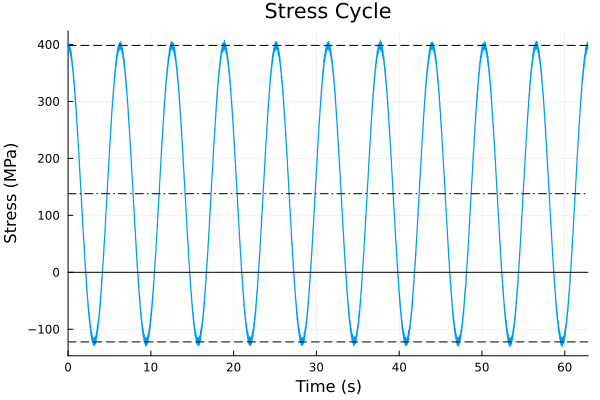

In [5]:
stress_amplitude, stress_mean = sn_stress[2], 138e6
println("Stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Mean stress: $(stress_mean*1e-6) MPa")

# plot
plot(time, stress(stress_amplitude, stress_mean) * 1e-6, label=:none, xlabel="Time (s)", ylabel="Stress (MPa)", title="Stress Cycle", grid=true, xlims=[time[begin], time[end]])
hline!([0,], c=:black, label=:none)
hline!([stress_mean] * 1e-6, c=:black, label=:none, linestyle=:dashdot)
hline!([stress_mean + stress_amplitude, stress_mean - stress_amplitude] * 1e-6, c=:black, label=:none, linestyle=:dash)
plot!()

## **3.** OWENS
Calculating the effective S-N curve and total damage accounting for Goodman mean correction using OWENS.
### 3.1 Effective S-N Curves
#### 3.1.1 Example
We'll walk step-by-step for one case (same example as above). Note that this is merely a numerical trick to obtain the effective S-N curve when dealing with sinusoidal loading. We're doing this to compare with the experimental data as verification. A more realistic and straightforward use of OWENS to calculate the damage from an arbitrary stress signal is presented in Section 3.2.
First, we compute the rainflow count accounting for mean correction.

In [6]:
nbins_amplitude, nbins_mean = 21, 3
mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
nothing

The mean level at the center position corresponds to our desired mean level.

In [7]:
mean_bins_mid = ceil(Int, nbins_mean / 2)
display(mean_levels * 1e-6)
println("Real mean stress: $(stress_mean*1e-6) MPa")
println("Center bin mean stress: $(mean_levels[mean_bins_mid]*1e-6) MPa")
nothing

Real mean stress: 138.0 MPa
Center bin mean stress: 138.1614941570199 MPa


3-element Vector{Float64}:
 -37.968170723573515
 138.1614941570199
 314.29115903761334

The stress amplitude level at the final position corresponds to our desired mean level.

In [8]:
display(amplitude_levels * 1e-6)
println("Real stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Center bin stress amplitude: $(amplitude_levels[end]*1e-6) MPa")
nothing

Real stress amplitude: 260.3 MPa
Center bin stress amplitude: 263.42579058842006 MPa


21-element Vector{Float64}:
   6.42501928264301
  19.27505784793308
  32.1250964132218
  44.97513497851051
  57.82517354379923
  70.67521210908794
  83.52525067437666
  96.37528923966538
 109.2253278049541
 122.07536637024282
   ⋮
 160.625482066109
 173.47552063139773
 186.3255591966864
 199.17559776197515
 212.02563632726387
 224.87567489255258
 237.72571345784132
 250.57575202312998
 263.42579058842006

We can verify that the count at the corresponding bin is 10.

In [9]:
display(ncycles)
println("Cycles at desired bin: $(ncycles[end, mean_bins_mid])")
nothing

Cycles at desired bin: 10.0


21×3 Matrix{Float64}:
 12968.0  7291.0  13011.5
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     ⋮            
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0     0.0      0.0
     0.0    10.0      0.0

The effective amplitude is higher than the real amplitude due to the effect of the non-zero mean.

In [10]:
println("Real stress amplitude: $(stress_amplitude*1e-6) MPa")
println("Effective stress amplitude: $(amplitude_levels_effective[end, mean_bins_mid]*1e-6) MPa")
nothing

Real stress amplitude: 260.3 MPa
Effective stress amplitude: 347.31714724997687 MPa


We now use the effective amplitude to calculate the number of cycles to failure for this amplitude and mean.

In [11]:
log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
nothing

The effective S-N point is then:

In [12]:
println("Point on effective S-N curve for mean=$(stress_mean*1e-6) MPa")
println("    N-cycles to failure: 10^$(log_ncycles_fail[end, mean_bins_mid])")
println("    Stress amplitude: $(stress_amplitude*1e-6) MPa")
nothing

Point on effective S-N curve for mean=138.0 MPa
    N-cycles to failure: 10^4.14174089596413
    Stress amplitude: 260.3 MPa


#### **3.1.2** Effective S-N Curves
The experimental S-N curve has a limited range, and because of the interpolation required (interpolation based on stress amplitude), we can only perform the verification for a few points.

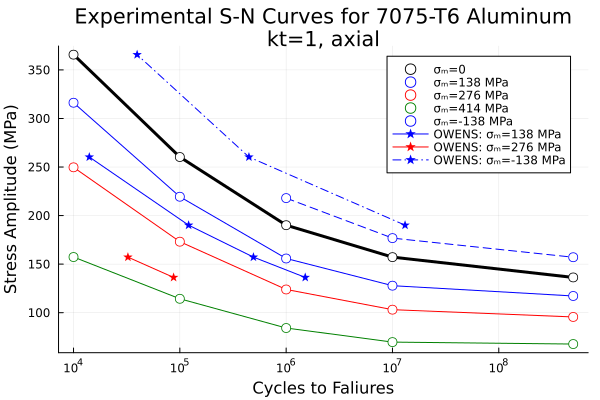

In [13]:
# 138
stress_mean = 138e6
stress_amplitudes_138 = sn_stress[1:4]
logN_138 = zeros(0)
for stress_amplitude in stress_amplitudes_138
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_138, log_ncycles_fail[end, mean_bins_mid])
end

# -138
stress_mean = -138e6
stress_amplitudes_n138 = sn_stress[3:5]
logN_n138 = zeros(0)
for stress_amplitude in stress_amplitudes_n138
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_n138, log_ncycles_fail[end, mean_bins_mid])
end

# 276
stress_mean = 276e6
stress_amplitudes_276 = sn_stress[1:2]
logN_276 = zeros(0)
for stress_amplitude in stress_amplitudes_276
    mean_levels, amplitude_levels, ncycles, amplitude_levels_effective = OWENS.rainflow_mean_corrected(stress(stress_amplitude, stress_mean), ultimate_strength; nbins_amplitude, nbins_mean)
    log_ncycles_fail = OWENS.sn_curve_mean_corrected(sn_stress, sn_log_cycles, amplitude_levels_effective)
    append!(logN_276, log_ncycles_fail[end, mean_bins_mid])
end

# plot
color_0 = :black
color_138, color_276, color_414 = :blue, :red, :green
markersize, markercolor = 5, :white
# mean
plot(ncycles_exp, mean_0, label=:none, color=color_0, lw=3, xaxis=:log, title="Experimental S-N Curves for 7075-T6 Aluminum\nkt=1, axial", xlabel="Cycles to Faliures", ylabel="Stress Amplitude (MPa)", legend=:topright, grid=true)
scatter!(ncycles_exp, mean_0, label="σₘ=0", color=markercolor, markerstrokecolor=color_0, markersize=markersize)
# positive
for (mean, color, label) in zip([mean_138, mean_276, mean_414], [color_138, color_276, color_414], [138, 276, 414])
    plot!(ncycles_exp, mean, label=:none, color=color)
    scatter!(ncycles_exp, mean, label="σₘ=$label MPa", color=markercolor, markerstrokecolor=color, markersize=markersize)
end
# negative
for (mean, color, label) in zip([mean_n138,], [color_138,], [-138,])
    plot!(ncycles_exp, mean, label=:none, color=color, linestyle=:dash)
    scatter!(ncycles_exp, mean, label="σₘ=$label MPa", color=markercolor, markerstrokecolor=color, markersize=markersize)
end
# Miner's rule + Goodman's correction
plot!(10 .^ logN_138, stress_amplitudes_138 * 1e-6, color=color_138, markershape=:star5, markerstrokecolor=color_138, markersize=markersize, label="OWENS: σₘ=138 MPa")
plot!(10 .^ logN_276, stress_amplitudes_276 * 1e-6, color=color_276, markershape=:star5, markerstrokecolor=color_276, markersize=markersize, label="OWENS: σₘ=276 MPa")
plot!(10 .^ logN_n138, stress_amplitudes_n138 * 1e-6, color=color_138, linestyle=:dashdot, markershape=:star5, markerstrokecolor=color_138, markersize=markersize, label="OWENS: σₘ=-138 MPa")
plot!()

### **3.2** Damage
In most cases we simply want to calculate the damage (not plot effective S-N curves as above) due to an arbitrary stress timeseries. We can do this with a single function call to OWENS. The damage is calculated using Miner's rule with Goodman's mean correction. A damage of 1 or greater indicates failure. We'll use a different example since the S-N curves above do not cover a large enough range of stress amplitude for calculating damage from a random signal.

#### **3.2.1** Stress Time Series
Let's create a random stress timeseries.

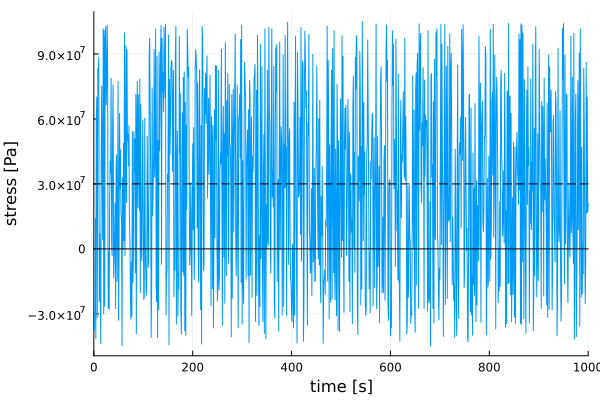

In [14]:
amplitude, mean = 150e6, 30e6
time = 1:1000
rng = Xoshiro(1) # seed for reproducibility
stress_timeseries = (rand(rng, length(time)) .- 0.5) * amplitude .+ mean

plot(time, stress_timeseries; xlabel="time [s]", ylabel="stress [Pa]", label=nothing, xlim=(0, Inf))
hline!([mean], label=nothing, color=:black, linestyle=:dash)
hline!([0], label=nothing, color=:black, linestyle=:solid)
plot!()

#### **3.2.2** Material Properties

Ultimate strength: 5.0e8 Pa


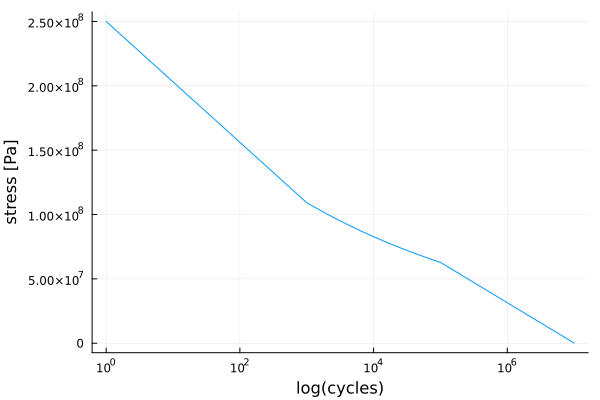

In [15]:
# Ultimate strength
ultimate_strength = 500e6
println("Ultimate strength: ", ultimate_strength, " Pa")
nothing

# S-N curve
failure_strength_coefficient = 250e6
fatigue_exponent = -0.12
ncycles = 1:1000:(1e5+1)
sn_log_cycles = log10.(ncycles)
sn_stress = failure_strength_coefficient * ncycles .^ fatigue_exponent
ncycles = vcat(ncycles, 1e7)
sn_log_cycles = vcat(sn_log_cycles, log10(1e7))
sn_stress = vcat(sn_stress, 1e5)
plot(ncycles, sn_stress; xscale=:log10, xlabel="log(cycles)", ylabel="stress [Pa]", label=nothing)
plot!()

#### **3.2.3** Fatigue Damage

In [16]:
damage = OWENS.fatigue_damage(stress_timeseries, sn_stress, sn_log_cycles, ultimate_strength; nbins_amplitude=21, nbins_mean=3, mean_correction=true)
println("Damage: ", damage)
nothing

Damage: 0.0026325250504652636


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*